<a href='http://moncoachdata.com'><img src= 'https://moncoachdata.com/wp-content/uploads/MonCoachData-cours/MonCoachData.jpg' width=400/></a>


---


<center><em>Copyright MonCoachData (tous droits réservés)</em></center>
<center><em>Pour plus d'informations, visitez notre site <a href='http://moncoachdata.com'>moncoachdata.com</a></em></center>



---

# BONUS - Série temporelle multivariée avec RNN
---
----
# VEUILLEZ LIRE CE QUI SUIT AVANT DE PARCOURIR CE NOTEBOOK !

## NOTE : En général, il est très difficile d'obtenir de bonnes performances à partir d'un modèle RNN basé sur le LSTM pour les séries multivariées. Nous recommandons vivement l'utilisation des méthodes basées sur SARIMAX si vous avez une situation réelle nécessitant des données de séries temporelles à plusieurs variables.

## Veuillez ne pas poster de questions sur les forums Questions - Réponses concernant vos propres ensembles de données de séries temporelles. Les forums Q&R sont réservés aux notebooks et ensembles de données liés au cours. Postez les questions sur Discord pour vos propres ensembles de données.
---
---
Consommation d'énergie des appareils électroménagers : Un exemple de prévision de séries temporelles multivariées

Données expérimentales utilisées pour créer des modèles de régression de la consommation d'énergie des appareils dans un bâtiment à faible consommation d'énergie.



---



---



Informations sur les ensembles de données :

L'ensemble de données contient des enregistrements de différentes features toutes les 10 min pendant environ 4,5 mois. Les conditions de température et d'humidité de la maison ont été surveillées à l'aide d'un réseau de capteurs sans fil ZigBee. Chaque nœud sans fil a transmis les conditions de température et d'humidité pendant environ 3,3 min. Ensuite, la moyenne des données sans fil a été calculée sur des périodes de 10 minutes. Les données énergétiques ont été enregistrées toutes les 10 minutes avec des compteurs d'énergie m-bus. La météo de la station météorologique de l'aéroport le plus proche (aéroport de Chievres, Belgique) a été téléchargée à partir d'un ensemble de données publiques de Pronostic Fiable (rp5.ru), et fusionnée avec les ensembles de données expérimentales à l'aide de la colonne date et heure. Deux variables aléatoires ont été incluses dans l'ensemble de données pour tester les modèles de régression et pour filtrer les attributs non prédictifs (paramètres).

Source originale de l'ensemble de données :

https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
___
___

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Données

Lisons dans l'ensemble des données :

In [ ]:
df = pd.read_csv('energydata_complete.csv',index_col='date', 
                 infer_datetime_format=True)

In [ ]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

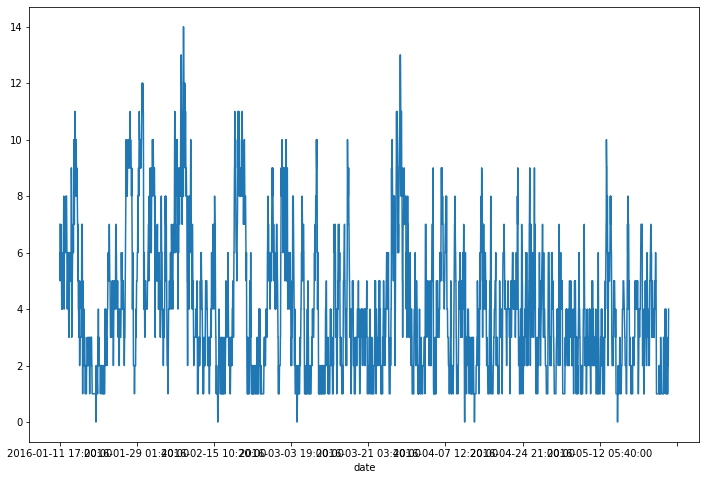

In [ ]:
df['Windspeed'].plot(figsize=(12,8))

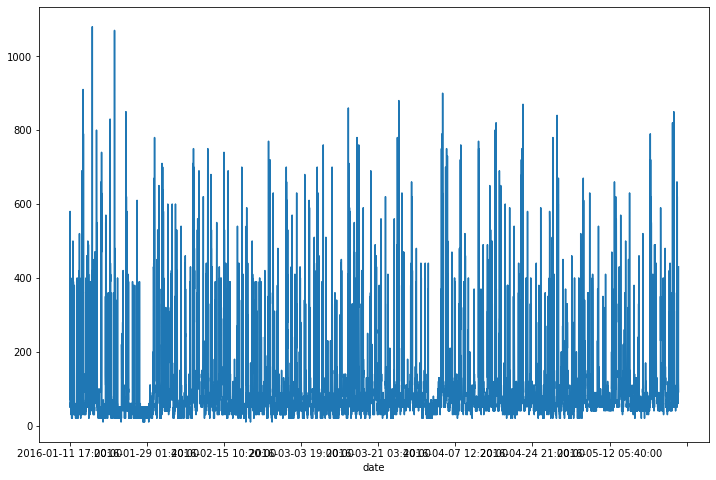

In [ ]:
df['Appliances'].plot(figsize=(12,8))

## Répartition Entraînement / Test

In [ ]:
len(df)

19735

In [ ]:
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [ ]:
df.tail(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


Imaginons que nous voulions prédire seulement 24 heures dans le futur, nous n'avons pas besoin de 3 mois de données pour cela, alors économisons un peu de temps d'entraînement et sélectionnons seulement les données des derniers mois.

In [ ]:
df.loc['2016-05-01':]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.200000,18.390000,41.400000,23.200000,36.400000,19.73,37.730000,19.50,47.290000,4.800000,40.060000,19.500000,31.600000,22.2000,40.000000,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.172500,18.390000,41.500000,23.133333,36.466667,19.70,37.663333,19.50,47.290000,4.800000,40.090000,19.500000,31.600000,22.2000,40.400000,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.090000,18.323333,41.500000,23.200000,36.500000,19.70,37.590000,19.50,47.260000,4.660000,40.030000,19.500000,31.600000,22.2000,41.000000,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.090000,18.290000,41.500000,23.200000,36.500000,19.70,37.500000,19.50,47.260000,4.530000,41.300000,19.500000,31.600000,22.2000,41.333333,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.030000,18.290000,41.560000,23.200000,36.500000,19.70,37.500000,19.50,47.200000,4.590000,41.833333,19.500000,31.600000,22.2000,41.626667,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,23.20,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.70,45.590000,23.23,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.70,45.730000,23.23,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


In [ ]:
df = df.loc['2016-05-01':]

Arrondissons également les données, avec une précision d'une décimale, sinon cela pourrait causer des problèmes avec notre réseau (nous normaliserons également les données de toute façon, donc ce niveau de précision ne nous est pas utile)

In [ ]:
df = df.round(2)

In [ ]:
len(df)

3853

In [ ]:
# Combien de lignes par jour ? Nous savons que c'est toutes les 10 minutes
24*60/10

144.0

In [ ]:
test_days = 2

In [ ]:
test_ind = test_days*144

In [ ]:
test_ind

288

In [ ]:
# Remarquez le signe moins dans notre indexation

train = df.iloc[:-test_ind]
test = df.iloc [-test_ind :]

In [ ]:
train

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,19.50,47.29,4.80,40.06,19.50,31.60,22.20,40.00,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,19.50,47.29,4.80,40.09,19.50,31.60,22.20,40.40,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,19.50,47.26,4.66,40.03,19.50,31.60,22.20,41.00,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,19.50,47.26,4.53,41.30,19.50,31.60,22.20,41.33,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,19.50,47.20,4.59,41.83,19.50,31.60,22.20,41.63,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-25 17:20:00,120,0,24.50,37.22,24.13,34.30,25.20,37.64,24.36,38.29,20.85,51.59,19.57,1.00,23.24,34.29,24.50,38.97,21.89,37.03,16.17,756.17,52.67,1.33,31.33,6.43,33.46,33.46
2016-05-25 17:30:00,190,0,24.50,37.16,24.10,34.30,25.20,37.55,24.29,38.16,20.89,51.59,19.26,1.00,23.20,34.29,24.39,38.79,21.89,37.20,16.25,756.15,53.50,1.50,33.50,6.75,0.43,0.43
2016-05-25 17:40:00,160,0,24.50,37.43,24.10,34.43,25.14,37.28,24.29,38.00,21.00,51.59,19.20,1.00,23.25,34.45,24.39,38.74,21.89,37.33,16.33,756.13,54.33,1.67,35.67,7.07,16.67,16.67


In [ ]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


## Mise à l'échelle des données

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Générateur de séries temporelles

Cette classe examine une série de points de données recueillis à
des intervalles égaux, ainsi que des paramètres de séries temporelles tels stride, length , etc., afin de produire des lots pour
l'entraînement/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# définir le générateur
length = 144 # Longueur des séquences de sortie (en nombre de pas temporel)
batch_size = 1 # Nombre d'échantillons de séries temporelles dans chaque batch (lot)
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length=length, batch_size=batch_size)

In [ ]:
len(scaled_train)

3565

In [ ]:
len(generator) 

3421

In [ ]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [ ]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Cela prédit ce y : 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


Vous allez maintenant pouvoir modifier la longueur de manière à ce qu'elle ait un sens pour votre série temporelle !

## Création du Modèle

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
scaled_train.shape

(3565, 28)

In [ ]:
# définir le modèle
model = Sequential()

# Couche LSTM
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Prédiction finale (un neurone par feature ou caractéristique)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [ ]:
model.fit(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10
3421/3421 [==============================] - 92s 27ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 2/10
3421/3421 [==============================] - 92s 27ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 3/10
3421/3421 [==============================] - 92s 27ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 4/10
3421/3421 [==============================] - 92s 27ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 5/10
3421/3421 [==============================] - 94s 27ms/step - loss: 0.0073 - val_loss: 0.0081


In [ ]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

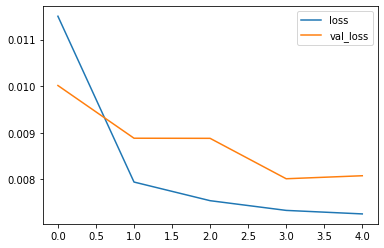

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Évaluation sur les données de test

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [ ]:
model.predict(first_eval_batch)

array([[ 0.09076366,  0.01053339,  0.70547915,  0.38556656,  0.55999714,
         0.44058985,  0.42191607,  0.45248523,  0.70519763,  0.4199773 ,
         0.28850746,  0.3497885 ,  0.6677214 , -0.01556907,  0.63336575,
         0.39568582,  0.5154128 ,  0.32135275,  0.5202565 ,  0.3494454 ,
         0.610425  ,  0.5187751 ,  0.4469316 ,  0.2158036 ,  0.5958304 ,
         0.54192954,  0.49303994,  0.4977147 ]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

----

**NOTE : Soyez attentif ici aux résultats en sortie et de leurs dimensions. Ajoutez vos propres déclarations print() pour voir ce qu'il se passe vraiment !**

In [ ]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([ 0.09076366,  0.01053339,  0.70547915,  0.38556656,  0.55999714,
         0.44058985,  0.42191607,  0.45248523,  0.70519763,  0.4199773 ,
         0.28850746,  0.3497885 ,  0.6677214 , -0.01556907,  0.63336575,
         0.39568582,  0.5154128 ,  0.32135275,  0.5202565 ,  0.3494454 ,
         0.610425  ,  0.5187751 ,  0.4469316 ,  0.2158036 ,  0.5958304 ,
         0.54192954,  0.49303994,  0.4977147 ], dtype=float32),
 array([ 0.0751344 ,  0.01423256,  0.7072538 ,  0.39587703,  0.5625306 ,
         0.44802865,  0.41882455,  0.47561672,  0.6897596 ,  0.4215946 ,
         0.27047014,  0.33188692,  0.66431814, -0.02231297,  0.62950647,
         0.39604428,  0.5142715 ,  0.32514787,  0.49921778,  0.35081726,
         0.60015213,  0.51734185,  0.4580615 ,  0.21850652,  0.5928276 ,
         0.5419754 ,  0.4917864 ,  0.49626923], dtype=float32),
 array([ 0.07103417,  0.01213471,  0.70569634,  0.40243247,  0.5613817 ,
         0.45473292,  0.4151785 ,  0.49735883,  0.6748483 ,  0.425347

In [ ]:
scaled_test

array([[0.19480519, 0.        , 0.70017036, ..., 0.53372781, 0.76305783,
        0.76305783],
       [0.37662338, 0.        , 0.70017036, ..., 0.52840237, 0.62337402,
        0.62337402],
       [0.12987013, 0.        , 0.70017036, ..., 0.52366864, 0.08785271,
        0.08785271],
       ...,
       [0.32467532, 0.33333333, 0.87052811, ..., 0.86804734, 0.58415049,
        0.58415049],
       [0.51948052, 0.33333333, 0.87052811, ..., 0.86568047, 0.12627577,
        0.12627577],
       [0.53246753, 0.33333333, 0.87052811, ..., 0.86390533, 0.68260957,
        0.68260957]])

## Transformations inverses et Comparaison

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[ 89.88801688,   0.31600166,  24.53116258, ...,   7.75860928,
         24.64720559,  24.88080347],
       [ 77.85348535,   0.42697672,  24.54157989, ...,   7.7593839 ,
         24.58456594,  24.80857323],
       [ 74.69631143,   0.36404125,  24.53243754, ...,   7.7093373 ,
         24.44881292,  24.72576355],
       ...,
       [143.76178205,  14.7216922 ,  18.78885609, ...,  18.76639543,
          7.85292687,  18.53101382],
       [143.76179352,  14.7216922 ,  18.78885627, ...,  18.76639946,
          7.8529291 ,  18.53101084],
       [143.76177058,  14.72169399,  18.78885627, ...,  18.76639946,
          7.85292687,  18.53101084]])

In [ ]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


In [ ]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [ ]:
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,89.888017,0.316002,24.531163,37.680915,24.373164,35.277036,25.112481,37.331021,24.136383,37.976300,21.075690,50.502993,19.318478,0.100263,23.444559,34.638543,24.385473,38.936420,21.909385,37.429471,16.594370,755.928072,57.966802,2.158036,40.749823,7.758609,24.647206,24.880803
1,77.853485,0.426977,24.541580,37.966000,24.404756,35.527204,25.090407,37.768668,24.028317,38.011945,20.955922,49.444473,19.226590,-0.289466,23.417660,34.646640,24.378774,39.026250,21.795776,37.459226,16.343712,755.895394,58.812673,2.185065,40.569657,7.759384,24.584566,24.808573
2,74.696311,0.364041,24.532438,38.147258,24.390430,35.752668,25.064375,38.180029,23.923938,38.094649,20.818166,48.201769,19.084829,-0.630301,23.364985,34.706801,24.372048,39.087472,21.676282,37.429540,16.144201,755.882885,59.485509,2.200075,39.790243,7.709337,24.448813,24.725764
3,73.154725,0.280449,24.514143,38.289502,24.342549,35.934092,25.039714,38.541485,23.837058,38.189770,20.690277,47.023593,18.918874,-0.910201,23.294625,34.772879,24.354683,39.137690,21.557025,37.355306,15.961267,755.839657,59.936011,2.220842,38.907843,7.630963,24.283092,24.611430
4,72.005861,0.228651,24.494576,38.414094,24.286721,36.107642,25.021702,38.864209,23.768370,38.291657,20.574585,46.000501,18.747061,-1.104999,23.217475,34.843071,24.330476,39.183263,21.440688,37.265096,15.797643,755.771395,60.233246,2.253951,38.110222,7.539420,24.132021,24.501814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,143.761828,14.721690,18.788856,48.366769,20.941781,44.136193,15.288094,28.402878,20.346729,41.965276,18.608216,37.527301,33.915654,26.262580,8.659422,61.163689,25.820276,33.342070,5.889556,19.236714,17.999760,764.578478,89.428816,2.607653,46.697010,18.766395,7.852928,18.531014
284,143.761805,14.721690,18.788856,48.366768,20.941781,44.136197,15.288094,28.402878,20.346729,41.965278,18.608216,37.527301,33.915654,26.262577,8.659422,61.163694,25.820276,33.342070,5.889558,19.236713,17.999758,764.578481,89.428816,2.607654,46.697010,18.766395,7.852929,18.531008
285,143.761782,14.721692,18.788856,48.366769,20.941781,44.136197,15.288094,28.402878,20.346729,41.965278,18.608216,37.527298,33.915654,26.262578,8.659423,61.163692,25.820277,33.342069,5.889558,19.236714,17.999760,764.578481,89.428820,2.607655,46.697010,18.766395,7.852927,18.531014
286,143.761794,14.721692,18.788856,48.366768,20.941781,44.136193,15.288094,28.402879,20.346729,41.965280,18.608216,37.527298,33.915654,26.262577,8.659423,61.163689,25.820277,33.342068,5.889555,19.236713,17.999761,764.578478,89.428820,2.607655,46.697013,18.766399,7.852929,18.531011


**Excellent travail !**

## EXTRA :
### Notre modèle sauvegardé

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save("multivariate.h5")